## Importing all the necessary libraries

In [254]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # df processing, CSV file I/O (e.g. pd.read_csv)

# Input df files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotions-dataset-for-nlp/val.txt
/kaggle/input/emotions-dataset-for-nlp/test.txt
/kaggle/input/emotions-dataset-for-nlp/train.txt


In [255]:
!wget https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
--2022-12-13 18:00:59--  https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13881 (14K) [text/plain]
Saving to: ‘helper_prabowo_ml.py.9’

helper_prabowo_ml.p 100%[===================>]  13.56K  --.-KB/s    in 0.001s  

2022-12-13 18:00:59 (20.4 MB/s) - ‘helper_prabowo_ml.py.9’ saved [13881/13881]



In [256]:
!pip install transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [257]:
from helper_prabowo_ml import clean_html, remove_links, non_ascii, lower, email_address, removeStopWords, punct, remove_, remove_special_characters, remove_digits
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, re
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFBertModel
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.metrics import classification_report
from tensorflow.keras.utils import plot_model

## Loading the train, validation and test datasets

In [258]:
train = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/train.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')
val = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/val.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')
test = pd.read_csv("/kaggle/input/emotions-dataset-for-nlp/test.txt",names=['Input','Sentiment'],sep=';',encoding='utf-8')

## Combining the train, validation and test datasets into a single dataframe

In [259]:
df = pd.concat([train,val,test],axis=0)
df = df.sample(frac=0.1)
df = df.reset_index()
df.head()

,index,Input,Sentiment
0,110,i feel it rarely advances any worthwhile cause...,joy
1,14930,i have days weeks when i feel a little deprived,sadness
2,871,i feel suffocated and paranoid,fear
3,11109,i feel badly that my ability to be thrilled at...,joy
4,9070,i feel that your advice is only useful for the...,joy


In [260]:
df.drop('index',axis=1,inplace=True)

In [261]:
df.shape

(2000, 2)

## Text Preprocessing

In [262]:
def preprocess_data(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=lower)
    return data

In [263]:
preprocessed_df = preprocess_data(df,'Input')
preprocessed_df.head()

,Input,Sentiment
0,feel rarely advances worthwhile cause always s...,joy
1,days weeks feel little deprived,sadness
2,feel suffocated paranoid,fear
3,feel badly ability thrilled seeing something p...,joy
4,feel advice useful people already believe,joy


In [264]:
preprocessed_df['num_words'] = preprocessed_df.Input.apply(len)

In [265]:
preprocessed_df.head()

,Input,Sentiment,num_words
0,feel rarely advances worthwhile cause always s...,joy,115
1,days weeks feel little deprived,sadness,31
2,feel suffocated paranoid,fear,24
3,feel badly ability thrilled seeing something p...,joy,57
4,feel advice useful people already believe,joy,41


In [266]:
encoded_labels = {'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5} 

## Train-Test Split

In [267]:
train_data, test_data = train_test_split(preprocessed_df,test_size=0.3,random_state=101,shuffle=True,stratify=preprocessed_df.Sentiment)

## Loading the Tokenizer class and pretrained BERT model

In [268]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


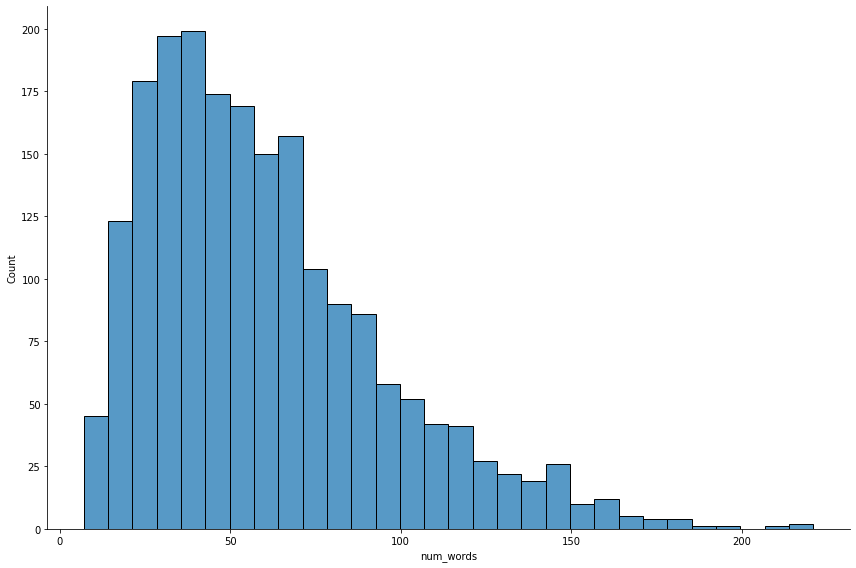

In [269]:
sns.displot(preprocessed_df.num_words,height=8,aspect=1.5)

In [270]:
max_len = 40

## Text Tokenization

In [271]:
X_train = tokenizer(text=train_data.Input.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                   )

X_test = tokenizer(text=test_data.Input.tolist(),
                   add_special_tokens=True,
                   return_tensors='tf',
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=True
                  )

## Defining the model architecture

In [272]:
input_ids = Input(shape=(max_len,),name='input_ids',dtype=tf.int32)
attention_mask = Input(shape=(max_len,),name='attention_mask',dtype=tf.int32)

In [273]:
embeddings = bert_model(input_ids,attention_mask=attention_mask)[0] # 0: final hidden state, 1: pooling output
output = GlobalMaxPool1D()(embeddings)
output = Dense(units=128,activation='relu')(output)
output = Dropout(0.1)(output)
output = Dense(units=64,activation='relu')(output)
output = Dense(units=32,activation='relu')(output)
y = Dense(units=6,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=y)
model.layers[2].trainable = True

## Compiling the model

In [274]:
model.compile(loss=CategoricalCrossentropy(from_logits=True),
              optimizer=Adam(learning_rate=5e-5,epsilon=1e-8,decay=0.01,clipnorm=1.0),
              metrics=CategoricalAccuracy('balanced_accuracy'))

## Encoding the emotion labels

In [275]:
train_data['Label'] = train_data.Sentiment.map(encoded_labels)
test_data['Label'] = test_data.Sentiment.map(encoded_labels)

In [276]:
train_data.head()

,Input,Sentiment,num_words,Label
1492,hurt feelings sorry,sadness,19,4
162,feel kinda weird andrea tries talk chris,fear,40,1
1372,feel ungrateful unhappy seem move properly,sadness,42,4
433,feel kids troubled homes feel ones could chang...,sadness,54,4
943,feel angry feel sad,anger,19,0


In [277]:
test_data.head()

,Input,Sentiment,num_words,Label
1445,basically wrote future self feeling generous t...,love,78,3
51,feel safer didnt horrible panicky feeling used...,sadness,90,4
670,cluded feelings violent acts committed,anger,38,0
581,feel hostile toward others fail nice,anger,36,0
1117,feeling invigorated ready keep pushing goa,joy,42,2


## Generating the model summary and plot

In [278]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 40)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 40)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_9 (TFBertModel)   TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_max_pooling1d_9 (GlobalM (None, 768)          0           tf_bert_model_9[0][0]      

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


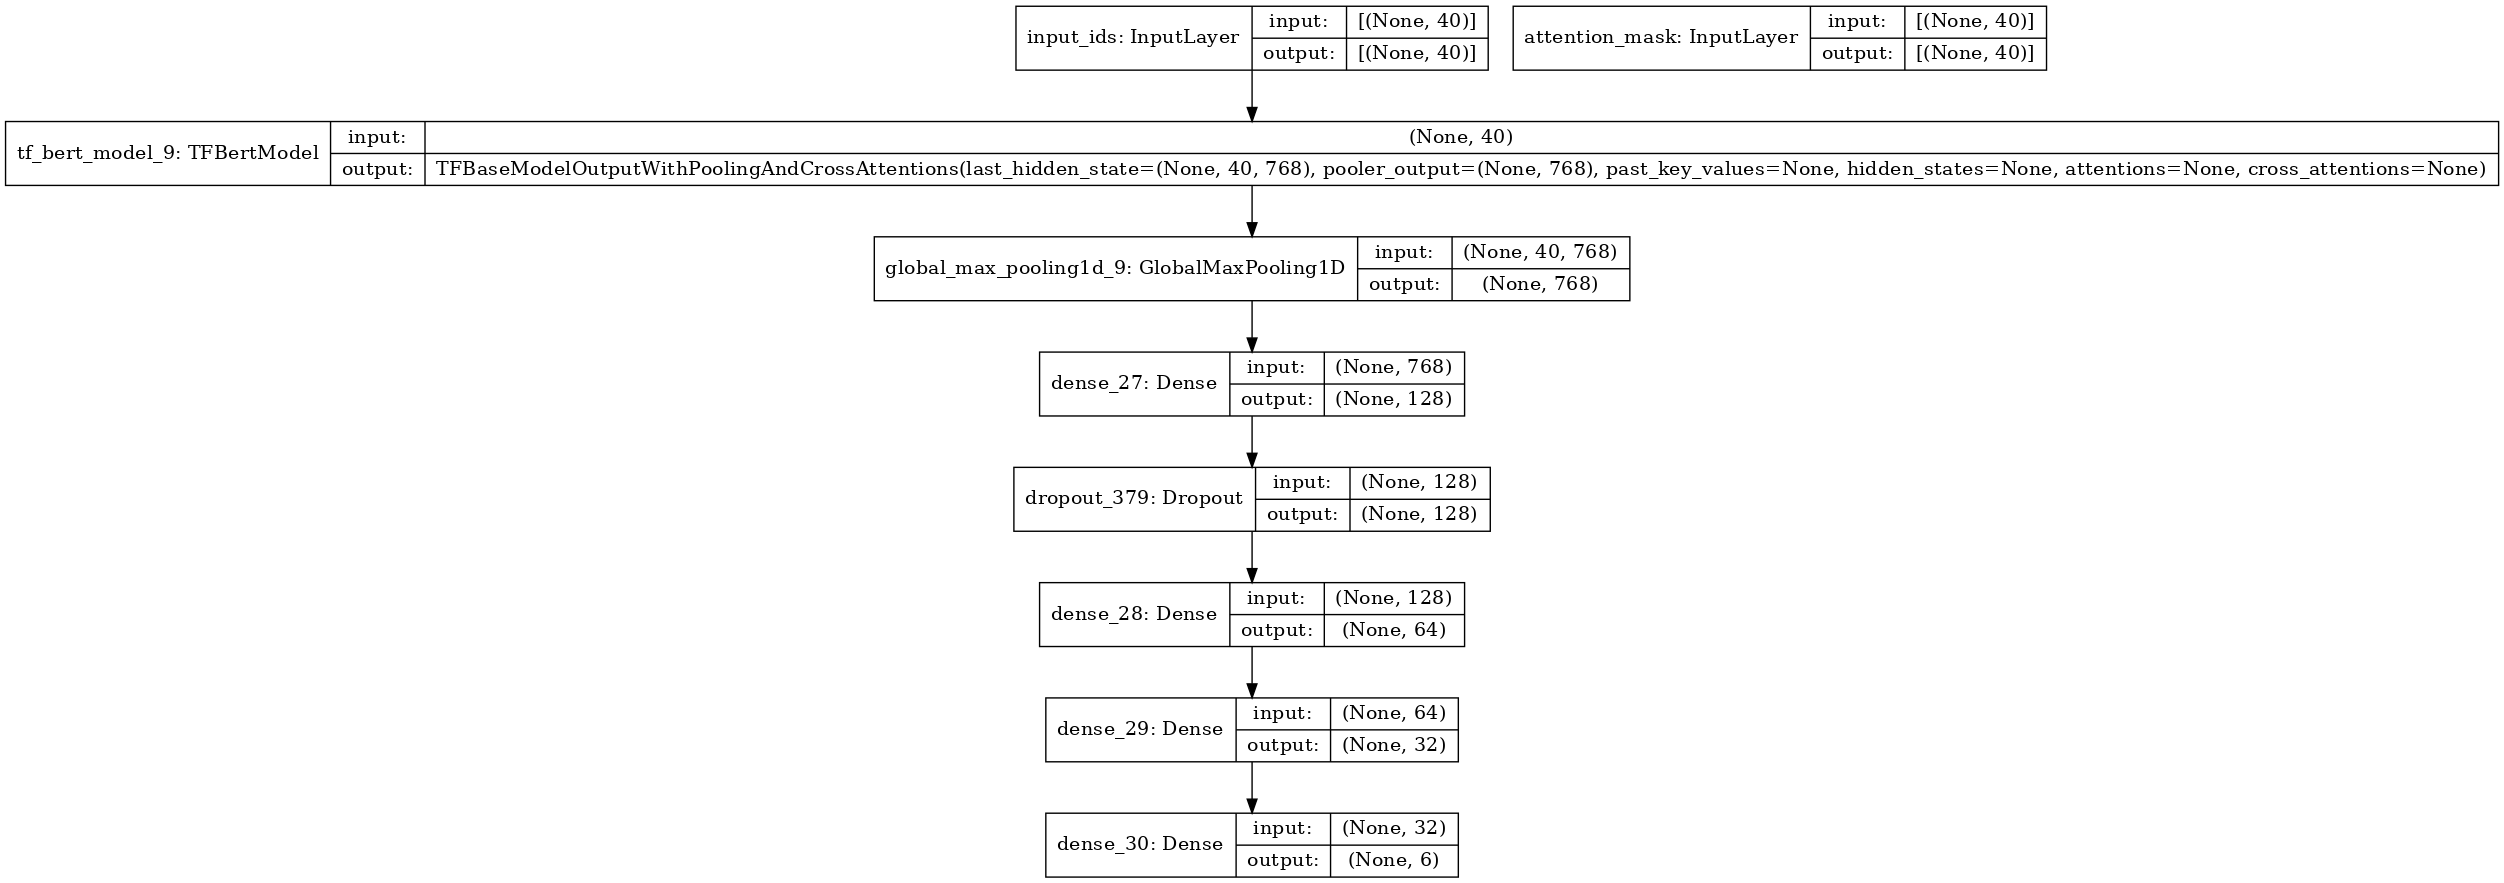

In [279]:
plot_model(model,'model.png',show_shapes=True,dpi=100)

## Training and fine-tuning the pretrained BERT model 

In [280]:
r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
             y=to_categorical(train_data.Label),
             epochs=10,
             batch_size=32,
             validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_data.Label))
             )

Epoch 1/10
44/44 [==============================] - 40s 413ms/step - loss: 1.6248 - balanced_accuracy: 0.3993 - val_loss: 1.3380 - val_balanced_accuracy: 0.5500
Epoch 2/10
44/44 [==============================] - 14s 312ms/step - loss: 1.1277 - balanced_accuracy: 0.6336 - val_loss: 0.8645 - val_balanced_accuracy: 0.7217
Epoch 3/10
44/44 [==============================] - 14s 321ms/step - loss: 0.6700 - balanced_accuracy: 0.8057 - val_loss: 0.5863 - val_balanced_accuracy: 0.8083
Epoch 4/10
44/44 [==============================] - 14s 329ms/step - loss: 0.3557 - balanced_accuracy: 0.8943 - val_loss: 0.4998 - val_balanced_accuracy: 0.8433
Epoch 5/10
44/44 [==============================] - 15s 331ms/step - loss: 0.2323 - balanced_accuracy: 0.9457 - val_loss: 0.4373 - val_balanced_accuracy: 0.8733
Epoch 6/10
44/44 [==============================] - 14s 323ms/step - loss: 0.1614 - balanced_accuracy: 0.9607 - val_loss: 0.4115 - val_balanced_accuracy: 0.8767
Epoch 7/10
44/44 [================

## Analyzing model performance

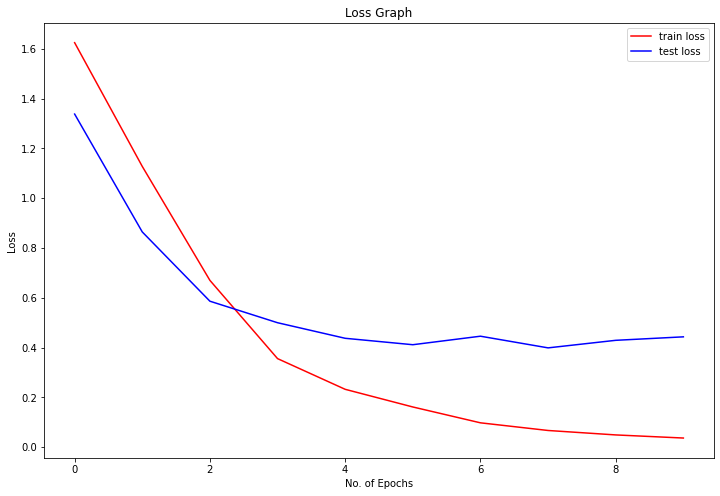

In [281]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

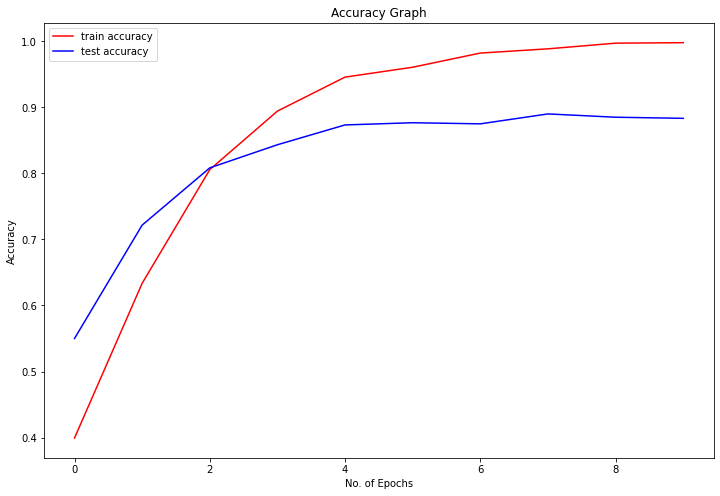

In [282]:
plt.figure(figsize=(12,8))
plt.plot(r.history['balanced_accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_balanced_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

## Saving the model

In [284]:
model.save("emotion_detector.h5")

## Evaluating the model on the test dataset

In [285]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_data.Label))
print("Test Categorical Cross-Entropy Loss:",loss)
print("Test Categorical Accuracy:",acc)

19/19 [==============================] - 5s 91ms/step - loss: 1.1729 - balanced_accuracy: 0.8833
Test Categorical Cross-Entropy Loss: 1.1729487180709839
Test Categorical Accuracy: 0.8833333253860474


In [286]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print(classification_report(test_data.Label,test_predictions))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89        77
           1       0.82      0.85      0.83        68
           2       0.93      0.89      0.91       209
           3       0.69      0.81      0.75        54
           4       0.92      0.92      0.92       173
           5       0.88      0.74      0.80        19

    accuracy                           0.88       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.89      0.88      0.88       600



The result is quite promising as we've obtained an excellent f1-score of almost 80% for all the 6 emotion classes.